In [2]:
import xarray as xr 
import numpy as np
import pandas as pd
import geopandas as gpd 
import rioxarray as rio
import rioxarray.merge as merge
import itslivetools
import urllib.request
import json
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from skimage.morphology import skeletonize
from itslivetools import *
from itslivetools import itslive_setup

## Read in data

### ITS_LIVE

In [3]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [4]:
url = itslivetools.find_granule_by_point(itslive_catalog, [88.2511, 27.9676])

In [5]:
dc = itslivetools.read_in_s3(url[0])

In [6]:
dc_bbox = itslivetools.get_bbox(dc, epsg = '32645')

epsg:32645


### NASADEM 

In [7]:
dem_dir = '/home/emmamarshall/Desktop/data/nasadem/'
dem_ls = os.listdir(dem_dir)
dem_ls = [dem_ls[element] for element in range(len(dem_ls)) if '.nc' in dem_ls[element]]

In [8]:
qgis_dem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/merged_dem_qgis.nc').squeeze()

In [9]:
#steps to do outside of function on entire data object (for dem and itslive): write crs
qgis_dem = qgis_dem.rio.write_crs('EPSG:4326')
dc = dc.rio.write_crs('EPSG:32645')
#reproject dem to local utm
dem_prj = qgis_dem.rio.reproject('EPSG:32645')

### RGI outlines

In [10]:
rgi = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, dc_bbox, how='inner')

In [11]:
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2696,RGI60-15.02697,G088184E27891N,20001108,-9999999,88.183836,27.890705,15,2,0.526,5512,...,1239,0,0,0,0,9,9,None,"POLYGON ((616219.593 3085917.382, 616223.232 3...",0
2697,RGI60-15.02698,G088155E27898N,20001108,-9999999,88.155126,27.898019,15,2,11.710,5202,...,7398,0,0,0,0,9,9,None,"POLYGON ((617373.178 3088393.887, 617410.220 3...",0
2698,RGI60-15.02699,G088130E27874N,20001108,-9999999,88.129556,27.873683,15,2,3.011,6798,...,2134,0,0,0,0,9,9,None,"POLYGON ((612141.972 3083076.812, 612110.222 3...",0
2699,RGI60-15.02700,G088184E27900N,20001108,-9999999,88.183625,27.899983,15,2,0.313,5392,...,970,0,0,0,0,9,9,None,"POLYGON ((616267.486 3086560.269, 616241.741 3...",0
2700,RGI60-15.02701,G088226E27869N,20001108,-9999999,88.226304,27.868729,15,2,0.081,5721,...,261,0,0,0,0,9,9,None,"POLYGON ((620545.118 3083321.350, 620549.409 3...",0


In [12]:
#list of glaciers w/ term type specified
term_types = pd.read_csv('hma_glacier_term_types_1021.csv')
term_types.head()

,RGI_ID,TermType
0,RGI60-15.10463,Lake
1,RGI60-15.10464,Lake
2,RGI60-15.10467,possible
3,RGI60-15.1047,possible
4,RGI60-15.03253,possible


In [89]:
#just the glaciers that i've categorized term type for so far
rgi_set = rgi_sub.loc[rgi_sub['RGIId'].isin(term_types['RGI_ID'])]
rgi_set.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2930,RGI60-15.02931,G088625E27980N,20001108,-9999999,88.625432,27.980324,15,2,0.509,4990,...,1231,0,0,0,0,9,9,None,"POLYGON ((659836.912 3095659.197, 659778.703 3...",0
3251,RGI60-15.03252,G088527E27987N,20001226,-9999999,88.526741,27.986635,15,2,0.695,4971,...,1860,0,0,0,0,9,9,None,"POLYGON ((650180.120 3097075.800, 650174.821 3...",0
3252,RGI60-15.03253,G088519E27998N,20001226,-9999999,88.519156,27.998086,15,2,2.324,4954,...,3490,0,0,0,0,9,9,None,"POLYGON ((649166.828 3098704.766, 649198.432 3...",0
3255,RGI60-15.03256,G088545E28014N,20001226,-9999999,88.545391,28.014097,15,2,0.414,5347,...,1223,0,0,0,0,9,9,None,"POLYGON ((652414.559 3099827.434, 652358.242 3...",0
10379,RGI60-15.10380,G088017E27907N,20100128,-9999999,88.017000,27.907000,15,2,1.814,5556,...,2739,0,0,0,0,9,9,CN5O197B0122,"POLYGON ((600756.444 3087390.547, 600800.221 3...",0


In [90]:
#glims ids of the term type categorized glaciers, to be used to extract centerlines
glims_set = rgi_set['GLIMSId']

### Centerline data

In [91]:
sa_east_ablationlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_ablationlines/15_rgi60_SouthAsiaEast_Ablationlines.shp')
sa_east_centerlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_centerlines/15_rgi60_SouthAsiaEast_final_lines.shp')
sa_east_lowestPoints = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_lowestPoints/15_rgi60_SouthAsiaEast_minimumpoints.shp')

In [174]:
rgi_set.loc[rgi_set['RGIId'] == 'RGI60-15.10444']

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
10443,RGI60-15.10444,G088132E27989N,20100128,-9999999,88.132,27.989,15,2,5.486,5705,...,4792,0,0,1,0,9,9,CN5O197B0043,"POLYGON ((609813.543 3097656.632, 609825.527 3...",0


In [175]:
sa_east_ablationlines.loc[sa_east_ablationlines['GLIMS_ID'] == 'G088132E27989N']

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry


## Build IndGlacier objects

In [122]:
def ind_glacier_data_prep(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code):
    '''function to prepare data to create an object of the `IndGlacier` class for a single glacier.
    Pass in RGI ID of glacier of interest as well as full data objects of RGI gpdf, itslive datacube, 
    nasadem and the u tm code fo the glacier.I feel like at scale this is probably a really inefficient way to build objects'''
    
    #clip rgi to glacier
    single_rgi = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    print(single_rgi['RGIId'])
    #print(single_rgi)
    #extract glims id - will use to extract centerlines
    glims_id = single_rgi['GLIMSId'].values
    
    
    #clip dem and itslive
    dem_clip = dem_obj.rio.clip(single_rgi.geometry, dem_obj.rio.crs).squeeze().transpose()
    itslive_clip = itslive_dc.rio.clip(single_rgi.geometry, itslive_dc.rio.crs)
    dem_clip_downsamp = dem_clip.interp_like(itslive_clip, method = 'nearest')
    itslive_clip['z'] = dem_clip_downsamp.Band1
    
    #centerline objects
    centerline = centerlines.loc[centerlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    ablationline = ablationlines.loc[ablationlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    lowestpoint = lowestpoints.loc[lowestpoints['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    
    #flowline object
    
    #centerline = centerline.to_crs(utm_code)
    #ablationline = ablationline.to_crs(utm_code)
    #lowestpoint = lowestpoints.to_crs(
    
    #creat object of IndGlacier class
    rgi_outline = single_rgi
    glacier = IndGlacier(rgi_id, rgi_outline, dem_clip_downsamp, itslive_clip, centerline, ablationline, lowestpoint)
    
    return glacier

In [93]:
g10463 = ind_glacier_data_prep('RGI60-15.10463', rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10462    RGI60-15.10463
Name: RGIId, dtype: object


In [94]:
fl_10463 = g10463.calc_flowline()

In [95]:
fl_10463

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [107]:
land_terms = term_types.loc[term_types['TermType'] == 'Land']
lake_terms = term_types.loc[term_types['TermType'] == 'Lake']

In [128]:
land_ids = list(land_terms['RGI_ID'])
lake_ids = list(lake_terms['RGI_ID'])

In [141]:
land_ids = land_ids[:10]
lake_ids = lake_ids[:8]

In [140]:
rgi_set.loc[rgi_set['RGIId'] == 'RGI60-15.10662']

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right


In [176]:
land_ids_new = []

for element in range(len(land_ids)):
    if land_ids[element] == 'RGI60-15.10444':
        pass
    else:
        land_ids_new.append(land_ids[element])

In [177]:
land_ids_new

['RGI60-15.10458',
 'RGI60-15.10456',
 'RGI60-15.10446',
 'RGI60-15.10448',
 'RGI60-15.10426',
 'RGI60-15.10436',
 'RGI60-15.10442',
 'RGI60-15.10416',
 'RGI60-15.10404']

In [114]:
#land_ids = land_ids.remove('RGI60-15.10410')
#land_ids

In [100]:
#land_glaciers = [ind_glacier_data_prep(land_ids[g], rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645') for g in range(len(land_ids))]

In [181]:
def make_land_glacier_objects(land_ids_ls, rgi_gpdf, itslive, dem, centerlines, ablationlines, lowestpoint, epsg):
    
    land_glaciers = [] 
    
    for element in range(len(land_ids_ls)):
        
        land_glaciers.append(ind_glacier_data_prep(land_ids_ls[element], rgi_gpdf, itslive, dem, centerlines, ablationlines, lowestpoint, epsg))
        print('break')
        
    return land_glaciers
    
                            

In [182]:
land_glacier_ls = make_land_glacier_objects(land_ids_new, rgi_set, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10457    RGI60-15.10458
Name: RGIId, dtype: object
break
10455    RGI60-15.10456
Name: RGIId, dtype: object
break
10445    RGI60-15.10446
Name: RGIId, dtype: object
break
10447    RGI60-15.10448
Name: RGIId, dtype: object
break
10425    RGI60-15.10426
Name: RGIId, dtype: object
break
10435    RGI60-15.10436
Name: RGIId, dtype: object
break
10441    RGI60-15.10442
Name: RGIId, dtype: object
break
10415    RGI60-15.10416
Name: RGIId, dtype: object
break
10403    RGI60-15.10404
Name: RGIId, dtype: object
break


In [145]:
lake_glacier_ls = make_land_glacier_objects(lake_ids, rgi_set, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

10462    RGI60-15.10463
Name: RGIId, dtype: object
break
10463    RGI60-15.10464
Name: RGIId, dtype: object
break
2930    RGI60-15.02931
Name: RGIId, dtype: object
break
3255    RGI60-15.03256
Name: RGIId, dtype: object
break
10433    RGI60-15.10434
Name: RGIId, dtype: object
break
10406    RGI60-15.10407
Name: RGIId, dtype: object
break
10384    RGI60-15.10385
Name: RGIId, dtype: object
break
10379    RGI60-15.10380
Name: RGIId, dtype: object
break


In [169]:
ticker = 0

for element in range(len(land_glacier_ls)):
    print(land_glacier_ls[element].rgi_id)
    print(ticker)
    ticker += 1


RGI60-15.10458
0
RGI60-15.10456
1
RGI60-15.10446
2
RGI60-15.10448
3
RGI60-15.10444
4
RGI60-15.10426
5
RGI60-15.10436
6
RGI60-15.10442
7
RGI60-15.10416
8
RGI60-15.10404
9


In [180]:
lake_flowlines_dict = dict(zip(lake_ids, [lake_glacier_ls[g].calc_flowline() for g in range(len(lake_ids))]))
#land_dict = dict(zip(land_ids_new, [land_glacier_ls[g].calc_flowline() for g in range(len(land_ids))]))

In [186]:
land_flowlines_dict = dict(zip(land_ids_new, [land_glacier_ls[g].calc_flowline() for g in range(len(land_ids_new))]))

In [187]:
lake_dict.keys()

dict_keys(['RGI60-15.10463', 'RGI60-15.10464', 'RGI60-15.02931', 'RGI60-15.03256', 'RGI60-15.10434', 'RGI60-15.10407', 'RGI60-15.10385', 'RGI60-15.10380'])

In [150]:
lake_flowlines_dict['RGI60-15.10463']

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    crs                        int64 0
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * points                     (points) int64 220 219 218 217 216 ... 4 3 2 1 0
Data variables: (12/55)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    z                          (points) float64 5.988e+03 5.985e+03 ... nan nan
    distance                   (points) float64 4.405e+03 4.405e+03 ... 0.0
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

TypeError: nanmean() got an unexpected keyword argument 'di'

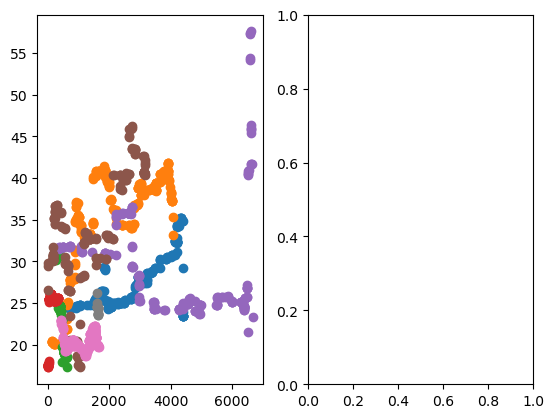

In [189]:
fig, axs = plt.subplots(ncols = 2) 

for element in lake_flowlines_dict.keys():
    
    glacier = lake_flowlines_dict[element]
    
    axs[0].scatter(glacier.distance, glacier.v.mean(dim='mid_date'))

for element in land_flowlines_dict.keys():
    
    glacier = land_flowlines_dict[element]
    
    axs[1].scatter(glacier.distance, glacier.v.mean(di='mid_ate'))


In [ ]:
x = fl_10463.distance
y = fl_10463.v.mean(dim='mid_date')
e = fl_10463.v_error.mean(dim='mid_date')
N=221
a = (100 * np.random.rand(N))
z = fl_10463.z